# An impact of adversarial data ovarsampling within imbalanced datasets on training image CNNs

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import Helper_functions as hf
import json
import copy
import imblearn
import sklearn

1


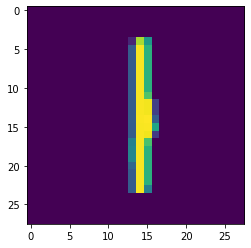

4


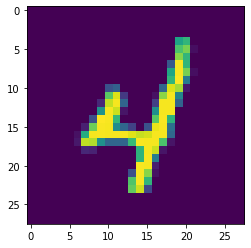

8


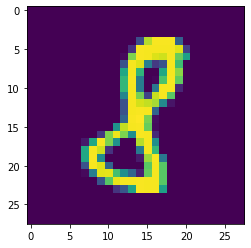

8


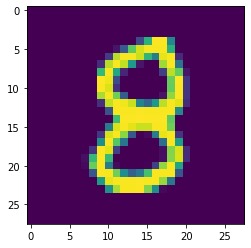

2


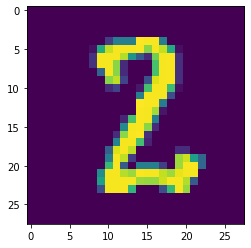

0


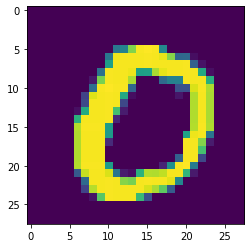

9


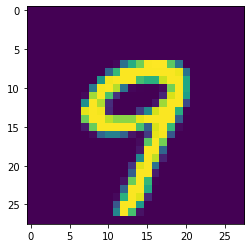

4


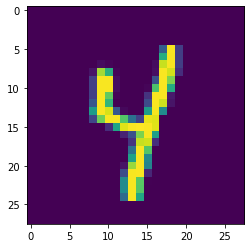

0


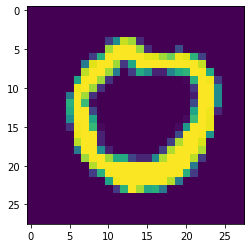

5


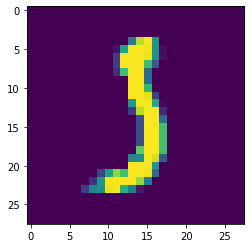

1


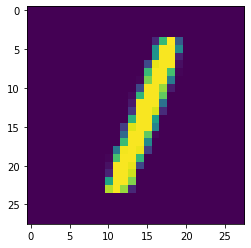

9


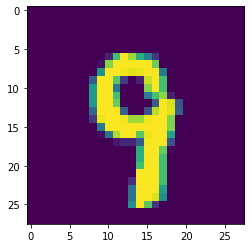

8


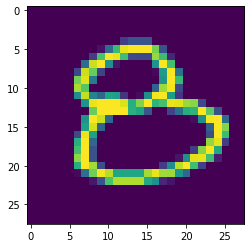

8


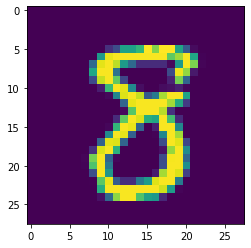

4


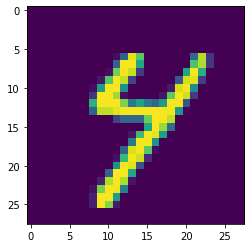

0


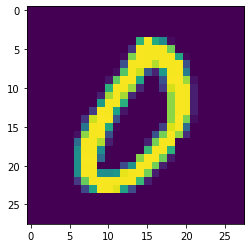

7


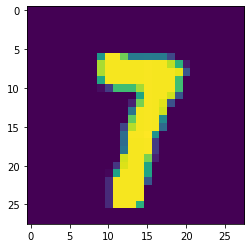

6


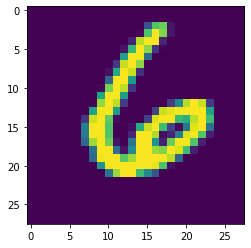

6


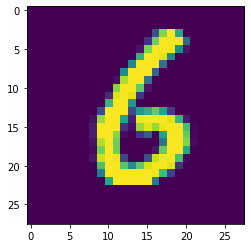

6


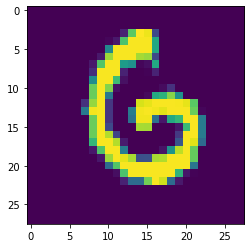

1


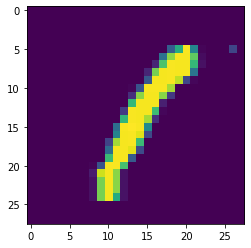

7


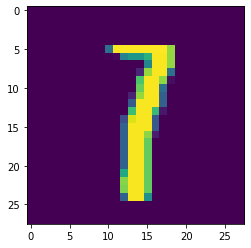

2


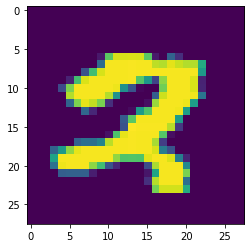

1


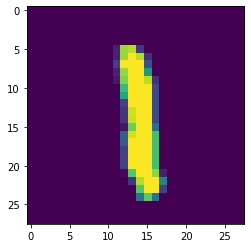

5


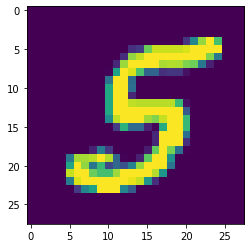

0


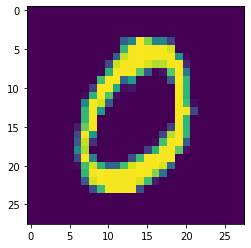

7


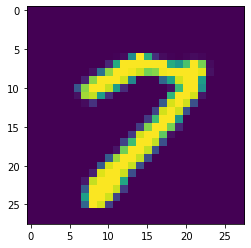

9


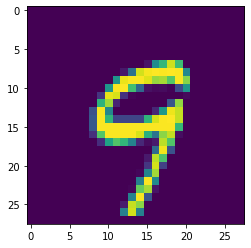

9


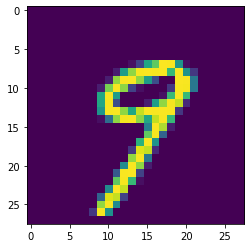

1


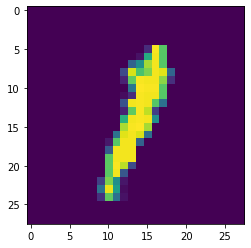

2


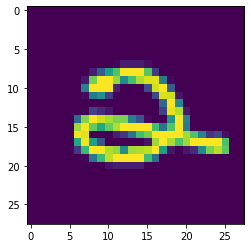

6


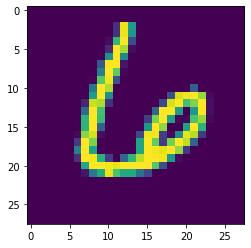

3


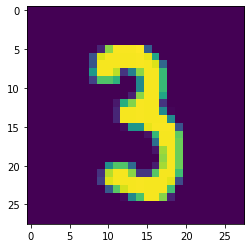

2


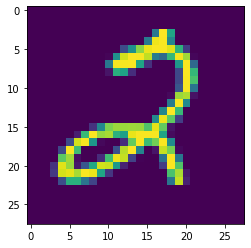

0


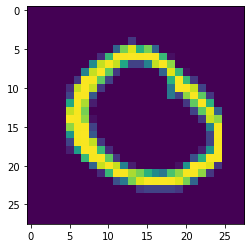

8


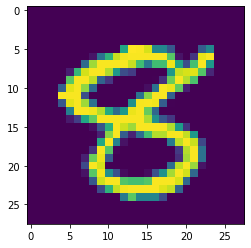

5


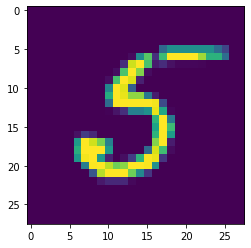

1


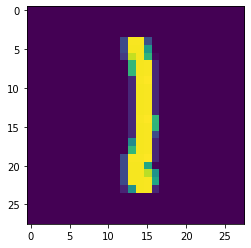

7


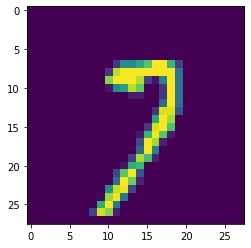

6


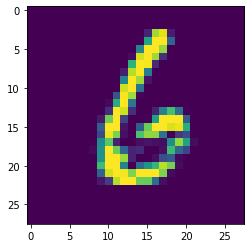

0


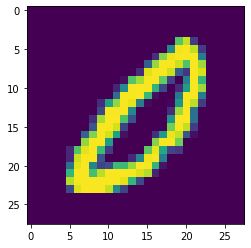

2


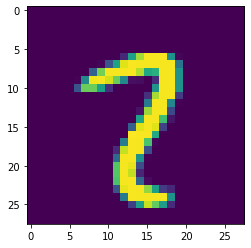

7


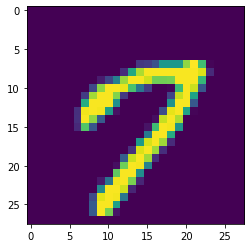

4


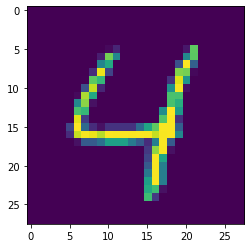

4


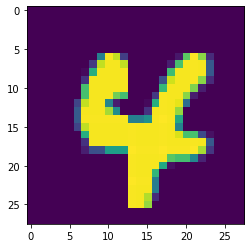

1


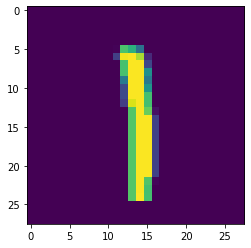

3


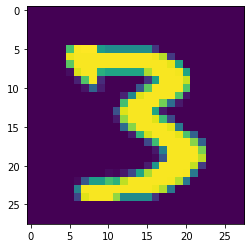

4


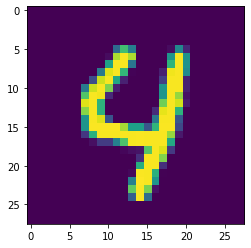

2


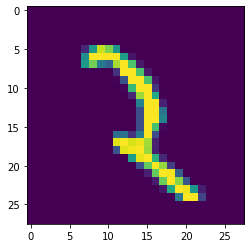

0


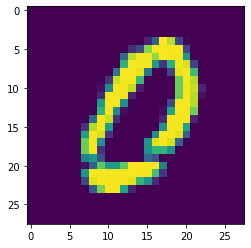

0


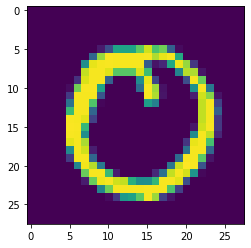

3


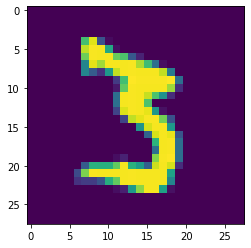

4


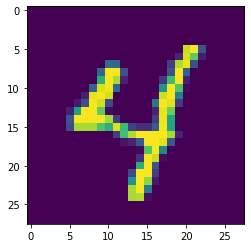

9


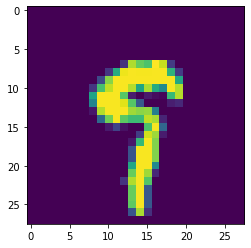

0


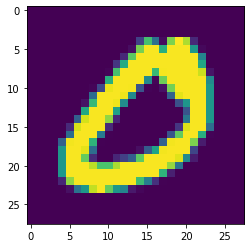

0


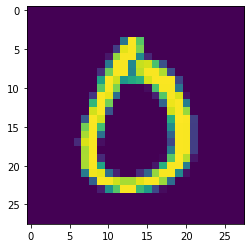

1


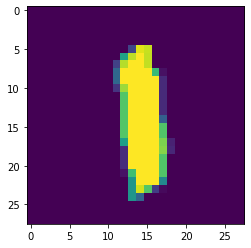

1


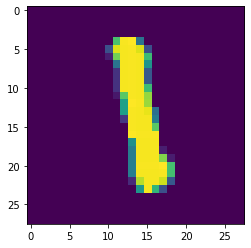

7


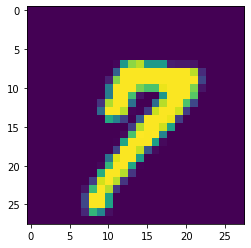

2


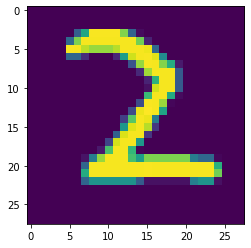

2


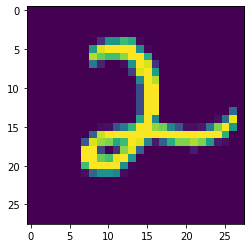

5


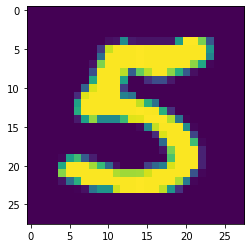

9


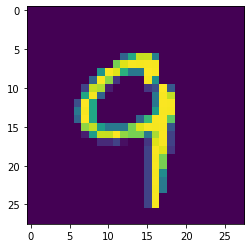

9


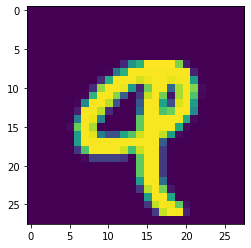

6


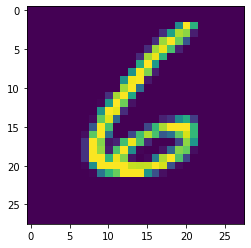

9


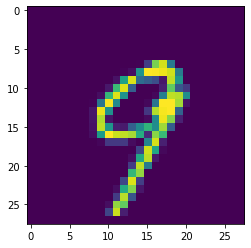

8


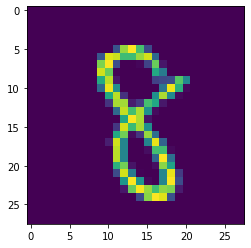

2


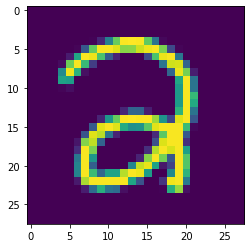

9


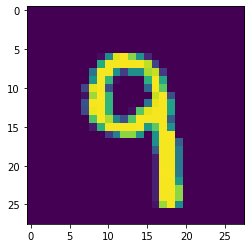

1


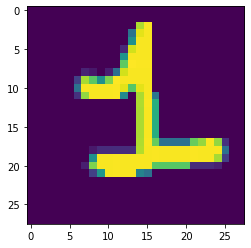

8


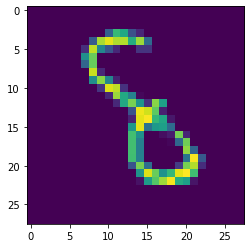

5


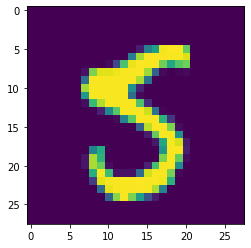

5


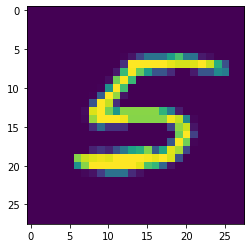

0


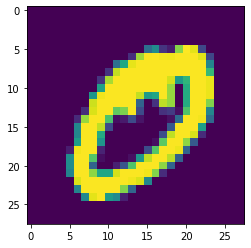

7


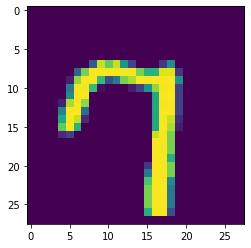

1


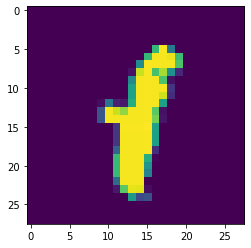

9


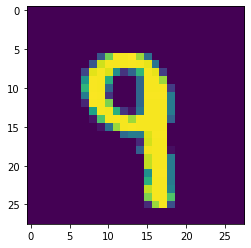

1


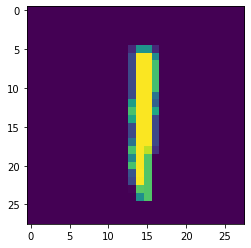

1


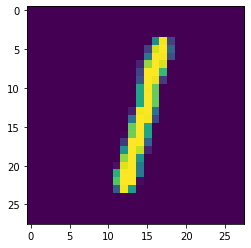

3


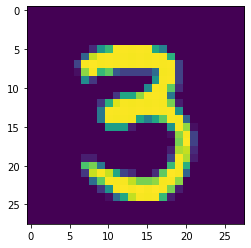

3


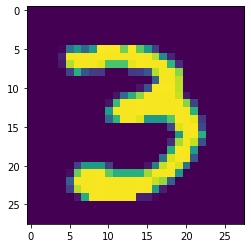

1


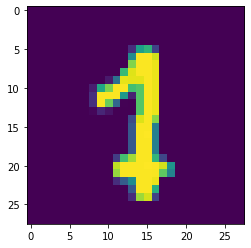

7


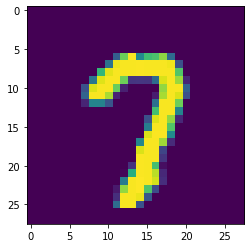

5


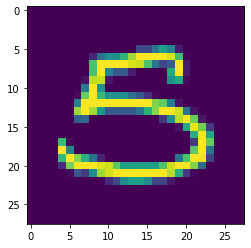

4


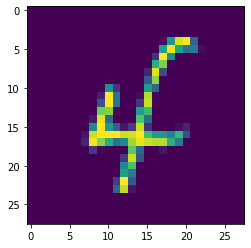

6


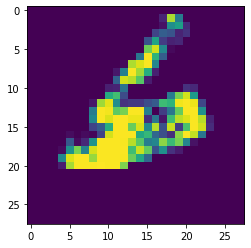

9


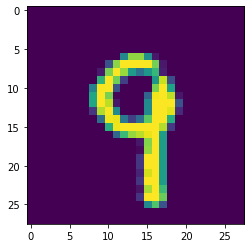

2


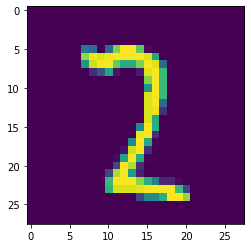

6


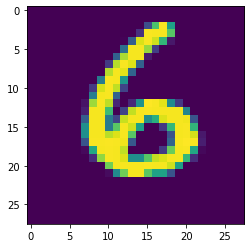

2


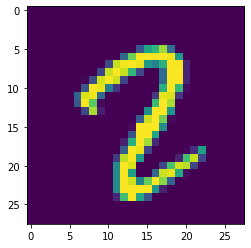

1


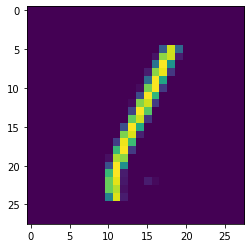

4


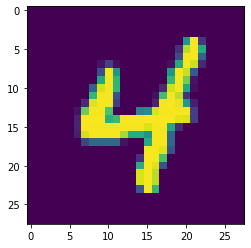

5


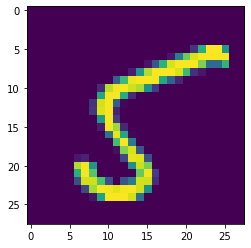

1


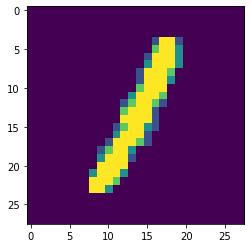

5


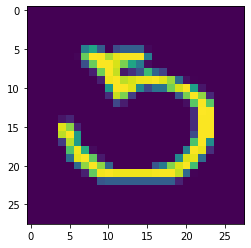

7


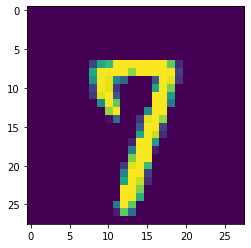

8


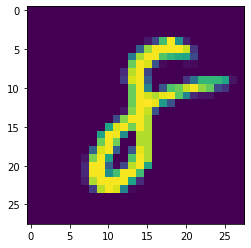

5


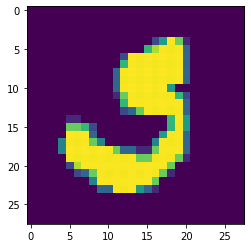

7


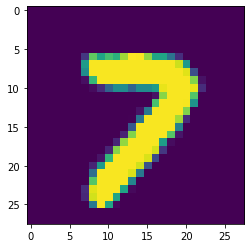

0


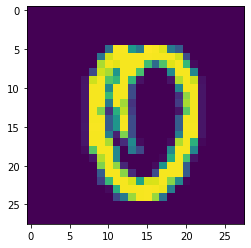

In [8]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
sss = sklearn.model_selection.StratifiedShuffleSplit(n_splits = 1, test_size = 0.05)
sss.get_n_splits(train_images, train_labels)
(train_indices, validation_indices) = next(sss.split(train_images, train_labels))
(validation_images, validation_labels) = (train_images[validation_indices], train_labels[validation_indices])
(train_images, train_labels) = (train_images[train_indices], train_labels[train_indices])

60k 28x28 train images with labels  
10k 28x28 validation images with labels

##  baseline model with balanced data

In [4]:
train_images_expanded = np.expand_dims(train_images, axis = 3)
validation_images_expanded = np.expand_dims(validation_images, axis = 3)
test_images_expanded = np.expand_dims(test_images, axis = 3)
with tf.device('CPU:0'):
    train_images_tf = tf.cast(train_images_expanded, dtype = tf.float32) / 255.0
    validation_images_tf = tf.cast(validation_images_expanded, dtype = tf.float32) / 255.0
    test_images_tf = tf.cast(test_images_expanded, dtype = tf.float32) / 255.0

In [5]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)
metrics = ['acc']
callbacks = list()

In [6]:
def model_run(model_name, epochs, ti, tl, vi, vl, optimizer, loss, metrics, callbacks):
    model_name.add(tf.keras.layers.Conv2D(28, (3, 3), activation = 'relu', padding = 'same', input_shape = (28, 28, 1)))
    model_name.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model_name.add(tf.keras.layers.Conv2D(56, (3, 3), padding = 'same', activation = 'relu'))
    model_name.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model_name.add(tf.keras.layers.Conv2D(56, (3, 3), padding = 'same', activation = 'relu'))
    model_name.add(tf.keras.layers.Flatten())
    model_name.add(tf.keras.layers.Dense(56, activation = 'relu'))
    model_name.add(tf.keras.layers.Dense(10))
    model_name.compile(optimizer = optimizer, 
                  loss = loss, 
                  metrics = metrics)
    with tf.device('GPU:0'):
        history = model_name.fit(
        ti, tl,
        epochs = epochs,
        validation_data = (vi, vl))
        model_name.summary()
    return history
def write_to_json(dictionary, gmean, fscore, filename):
    dictionary = copy.deepcopy(dictionary)
    for key in dictionary.keys():
        dictionary[key] = str(dictionary[key][-1])
    dictionary['gmean'] = str(gmean)
    dictionary['fscore'] = str(fscore)
    with open(filename, 'w') as f:
        json.dump(dictionary, f)

In [7]:
baseline = tf.keras.models.Sequential()
history = model_run(baseline, 20, train_images_tf, train_labels, validation_images_tf, validation_labels, 
          optimizer, loss, metrics, callbacks)
baseline.save('checkpoints/baseline.hdf5')

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 8s 159us/sample - loss: 0.4124 - acc: 0.8796 - val_loss: 0.1365 - val_acc: 0.9631
Epoch 2/20
50000/50000 [==============================] - 6s 125us/sample - loss: 0.1110 - acc: 0.9665 - val_loss: 0.0906 - val_acc: 0.9744
Epoch 3/20
50000/50000 [==============================] - 6s 126us/sample - loss: 0.0792 - acc: 0.9757 - val_loss: 0.0679 - val_acc: 0.9798
Epoch 4/20
50000/50000 [==============================] - 6s 125us/sample - loss: 0.0628 - acc: 0.9804 - val_loss: 0.0604 - val_acc: 0.9820
Epoch 5/20
50000/50000 [==============================] - 6s 125us/sample - loss: 0.0524 - acc: 0.9838 - val_loss: 0.0552 - val_acc: 0.9831
Epoch 6/20
50000/50000 [==============================] - 6s 125us/sample - loss: 0.0446 - acc: 0.9862 - val_loss: 0.0513 - val_acc: 0.9862
Epoch 7/20
50000/50000 [==============================] - 6s 126us/sample - loss: 0.0391 - acc: 0.9875 - val_l

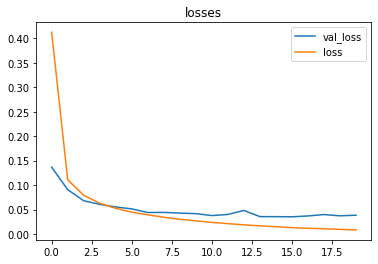

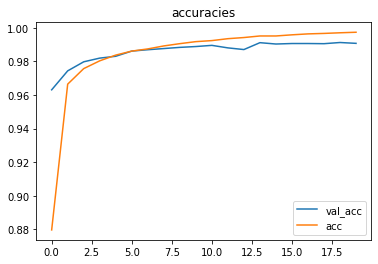

In [10]:
plt.title('losses')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.plot(history.history['loss'], label = 'loss')
plt.legend(loc = 'best')
plt.show()
plt.title('accuracies')
plt.plot(history.history['val_acc'], label = 'val_acc')
plt.plot(history.history['acc'], label = 'acc')
plt.legend(loc = 'best')
plt.show()

In [12]:
with tf.device('CPU:0'):
    baseline_test_preds = tf.argmax(baseline(test_images_tf), axis=-1)
    baseline_gmean = imblearn.metrics.geometric_mean_score(test_labels, baseline_test_preds, 
                                                           correction = np.finfo(np.float32).eps)
    baseline_fscore = sklearn.metrics.f1_score(test_labels, baseline_test_preds)
print(f'gmean: {baseline_gmean} \nfscore: {baseline_fscore}')

0.9892032903958768


In [ ]:
write_to_json(history.history, baseline_gmean, baseline_fscore, 'checkpoints/balanced/metrics_balanced.json')

## make imbalanced set $\mu=0.1 \rho=100$

{0: 4506, 1: 4506, 2: 45, 3: 4506, 4: 4506, 5: 4506, 6: 4506, 7: 45, 8: 45, 9: 45}


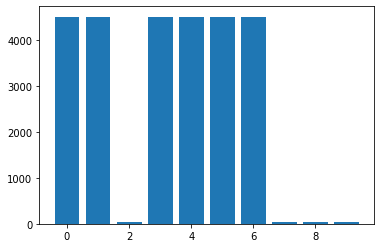

mu = 0.4, rho = 100.13333333333334


In [13]:
with tf.device('CPU:0'):
    (imb_train_images, imb_train_labels) = hf.Imbalance.change_set_statistics(train_images, 
                                                                              train_labels, 0.1, 100)
    sss = sklearn.model_selection.StratifiedShuffleSplit(n_splits = 1, test_size = 0.05)
    sss.get_n_splits(imb_train_images, imb_train_labels)
    (imb_train_indices, imb_validation_indices) = next(sss.split(imb_train_images, imb_train_labels))
    (imb_validation_images, imb_validation_labels) = (imb_train_images[imb_validation_indices], 
                                                      imb_train_labels[imb_validation_indices])
    (imb_train_images, imb_train_labels) = (imb_train_images[imb_train_indices], 
                                            imb_train_labels[imb_train_indices])
    print(hf.Imbalance.get_set_distribution(imb_train_labels))
    hf.Imbalance.plot_set_distribution(imb_train_images, imb_train_labels)
    imb_train_images_expanded = np.expand_dims(imb_train_images, axis = 3)
    imb_validation_images_expanded = np.expand_dims(imb_validation_images, axis = 3)
    imb_train_images_tf = tf.cast(imb_train_images_expanded, dtype = tf.float32) / 255.0
    imb_validation_images_tf = tf.cast(imb_validation_images_expanded, dtype = tf.float32) / 255.0

## check model behavior on untouched imbalanced set

In [14]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)
metrics = ['acc']
callbacks = list()

In [15]:
baseline = tf.keras.models.Sequential()
history = model_run(baseline, 20, imb_train_images_tf, imb_train_labels, 
                    imb_validation_images_tf, imb_validation_labels, 
          optimizer, loss, metrics, callbacks)

Train on 27216 samples, validate on 10000 samples
Epoch 1/20
27216/27216 [==============================] - 4s 156us/sample - loss: 0.3868 - acc: 0.8975 - val_loss: 1.7775 - val_acc: 0.5902
Epoch 2/20
27216/27216 [==============================] - 4s 136us/sample - loss: 0.0918 - acc: 0.9737 - val_loss: 0.9734 - val_acc: 0.6973
Epoch 3/20
27216/27216 [==============================] - 4s 136us/sample - loss: 0.0588 - acc: 0.9819 - val_loss: 0.6460 - val_acc: 0.7733
Epoch 4/20
27216/27216 [==============================] - 4s 136us/sample - loss: 0.0440 - acc: 0.9864 - val_loss: 0.6397 - val_acc: 0.7808
Epoch 5/20
27216/27216 [==============================] - 4s 137us/sample - loss: 0.0360 - acc: 0.9880 - val_loss: 0.5048 - val_acc: 0.8421
Epoch 6/20
27216/27216 [==============================] - 4s 137us/sample - loss: 0.0302 - acc: 0.9902 - val_loss: 0.4944 - val_acc: 0.8438
Epoch 7/20
27216/27216 [==============================] - 4s 136us/sample - loss: 0.0261 - acc: 0.9915 - val_l

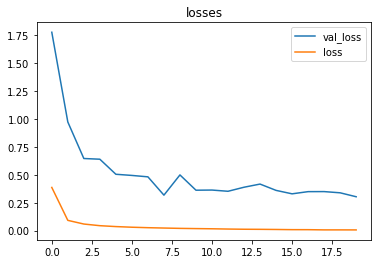

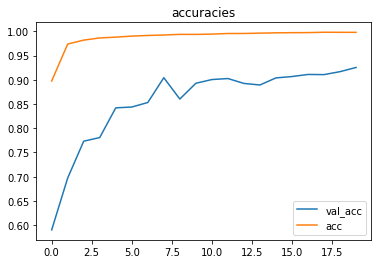

In [17]:
plt.title('losses')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.plot(history.history['loss'], label = 'loss')
plt.legend(loc = 'best')
plt.show()
plt.title('accuracies')
plt.plot(history.history['val_acc'], label = 'val_acc')
plt.plot(history.history['acc'], label = 'acc')
plt.legend(loc = 'best')
plt.show()

In [18]:
with tf.device('CPU:0'):
    baseline_test_preds = tf.argmax(baseline(test_images_tf), axis=-1)
    baseline_gmean = imblearn.metrics.geometric_mean_score(test_labels, baseline_test_preds, 
                                                           correction = np.finfo(np.float32).eps)
    baseline_fscore = sklearn.metrics.f1_score(test_labels, baseline_test_preds)
    print(f'gmean: {baseline_gmean} \nfscore: {baseline_fscore}')

0.9189903084622476


## train and evaluate model on randomly oversampled data

In [ ]:
hf.Imbalance.plot_set_distribution(imb_train_images, imb_train_labels)
ros = imblearn.over_sampling.RandomOverSampler(random_state = 0)
(ros_train_images, ros_train_labels) = ros.fit_resample(imb_train_images, imb_train_labels)
ros = imblearn.over_sampling.RandomOverSampler(random_state = 0)
(ros_validation_images, ros_validation_labels) = ros.fit_resample(imb_validation_images, 
                                                                  imb_validation_labels)
ros_train_images_expanded = np.expand_dims(ros_train_images, axis = 3)
ros_validation_images_expanded = np.expand_dims(ros_validation_images, axis = 3)
with tf.device('CPU:0'):
    ros_train_images_tf = tf.cast(ros_train_images_expanded, dtype = tf.float32) / 255.0
    ros_validation_images_tf = tf.cast(ros_validation_images_expanded, dtype = tf.float32) / 255.0

In [14]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)
metrics = ['acc']
callbacks = list()

In [15]:
model_ros = tf.keras.models.Sequential()
history = model_run(model_ros, 20, ros_train_images_tf, ros_train_labels, 
                    ros_validation_images_tf, ros_validation_labels, 
                    optimizer, loss, metrics, callbacks)

Train on 27216 samples, validate on 10000 samples
Epoch 1/20
27216/27216 [==============================] - 4s 156us/sample - loss: 0.3868 - acc: 0.8975 - val_loss: 1.7775 - val_acc: 0.5902
Epoch 2/20
27216/27216 [==============================] - 4s 136us/sample - loss: 0.0918 - acc: 0.9737 - val_loss: 0.9734 - val_acc: 0.6973
Epoch 3/20
27216/27216 [==============================] - 4s 136us/sample - loss: 0.0588 - acc: 0.9819 - val_loss: 0.6460 - val_acc: 0.7733
Epoch 4/20
27216/27216 [==============================] - 4s 136us/sample - loss: 0.0440 - acc: 0.9864 - val_loss: 0.6397 - val_acc: 0.7808
Epoch 5/20
27216/27216 [==============================] - 4s 137us/sample - loss: 0.0360 - acc: 0.9880 - val_loss: 0.5048 - val_acc: 0.8421
Epoch 6/20
27216/27216 [==============================] - 4s 137us/sample - loss: 0.0302 - acc: 0.9902 - val_loss: 0.4944 - val_acc: 0.8438
Epoch 7/20
27216/27216 [==============================] - 4s 136us/sample - loss: 0.0261 - acc: 0.9915 - val_l

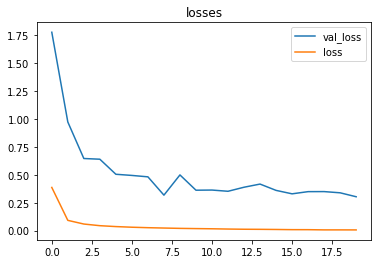

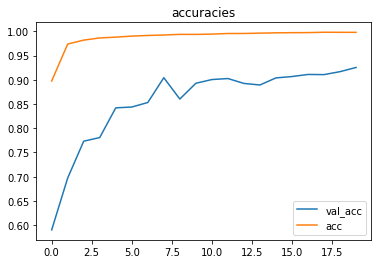

In [17]:
plt.title('losses')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.plot(history.history['loss'], label = 'loss')
plt.legend(loc = 'best')
plt.show()
plt.title('accuracies')
plt.plot(history.history['val_acc'], label = 'val_acc')
plt.plot(history.history['acc'], label = 'acc')
plt.legend(loc = 'best')
plt.show()

In [ ]:
with tf.device('CPU:0'):
    model_ros_test_preds = tf.argmax(model_ros(test_images_tf), axis=-1)
    model_ros_gmean = imblearn.metrics.geometric_mean_score(test_labels, model_ros_test_preds, 
                                                           correction = np.finfo(np.float32).eps)
    model_ros_fscore = sklearn.metrics.f1_score(test_labels, model_ros_test_preds)
    print(f'gmean: {model_ros_gmean} \nfscore: {model_ros_fscore}')